In [36]:
# Importamos las librerías

import nltk
import pandas as pd
from datetime import datetime
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px


In [120]:
# Leemos los archvios .csv de los comentarios

df_posts = pd.read_csv("twitter_post_sasil.csv", usecols=["css-4rbku5", "css-901oao 5", "css-901oao 7", "css-901oao 8", "css-901oao 9", "css-901oao 10", "css-901oao 11", "css-4rbku5 2"])
df_posts = df_posts.rename(columns= {
    "css-4rbku5": "fecha", "css-901oao 5": "texto", "css-901oao 7": "comentarios", "css-901oao 8":"rts",
    "css-901oao 9":"likes", "css-901oao 10":"views", "css-4rbku5 2":"hashtags", "css-901oao 11":"texto2"})
#df_posts['texto_limpio'] = df_posts['texto'].str.lower().str.replace('[^a-zA-Z\s]', '', regex=True)
# Concatenar las columnas

#palabras_df = df_posts.copy()
df_posts

,fecha,texto,comentarios,rts,likes,views,hashtags,texto2
0,6 sept.,México está listo para tener a la primera Pres...,5,8,56,3.809,NaN,NaN
1,52min,Trabajar por más de una década en favor de las...,2,4,NaN,153,#5toInforme,Mostrar más
2,9h,¡Por la continuidad de la transformación en Ch...,23,27,92,5.692,#estiempodetransformacion,NaN
3,13h,| Comenzamos la semana dialogando con,2,1,7,701,#Entrevista,En Vivo | Oscar Mario Beteta | Lunes 25/09/23
4,24 sept.,"Cuando me pregunten si me registraré, habrá se...",2,14,46,2.503,NaN,NaN
...,...,...,...,...,...,...,...,...
674,9 abr. 2022,Mañana todas y todos podemos participar en est...,4,7,10,NaN,NaN,NaN
675,7 abr. 2022,Este domingo sal a participar en la consulta de,6,12,NaN,NaN,#RevocaciónDeMandato,NaN
676,7 abr. 2022,Hoy en su cumpleaños quiero enviar una felicit...,9,4,36,NaN,NaN,NaN
677,7 abr. 2022,Este domingo sal a participar en la consulta de,6,12,NaN,NaN,#RevocaciónDeMandato,NaN


In [42]:
df_views = df_posts[["comentarios", "rts", "likes", "views"]]
df_views = df_views.fillna(0)
df_views.describe()

,comentarios,rts,likes,views
count,679,679,679,679
unique,55,62,129,326
top,1,0,0,0
freq,199,68,401,316


In [10]:
# Linea temporal
ts = df_posts[["fecha"]]
ts = ts.dropna()

# Utilizamos una expresión regular para identificar las fechas que son diferentes a números y que comienzan con "#" o alguna letra
ts_cleaned = ts[~ts['fecha'].str.match(r'^[^0-9]|\#')]
ts_cleaned

,fecha
0,6 sept.
1,52min
2,9h
3,13h
4,24 sept.
...,...
673,10 abr. 2022
674,9 abr. 2022
675,7 abr. 2022
676,7 abr. 2022


In [11]:
def obtener_fecha(string_fecha):
    # Diccionario para mapear los nombres abreviados de los meses a sus números correspondientes
    meses_dict = {
        'ene.': '01', 'feb.': '02', 'mar.': '03', 'abr.': '04', 'may.': '05', 'jun.': '06',
        'jul.': '07', 'ago.': '08', 'sept.': '09', 'oct.': '10', 'nov.': '11', 'dic.': '12'
    }

    try:
        # Verificar si el string está en formato 'Xh' y obtener la hora si es el caso
        if string_fecha.endswith('h'):
            hora = int(string_fecha.replace('h', ''))
            fecha_actual = datetime.now().replace(hour=hora, minute=0, second=0, microsecond=0)
        else:
            # Verificar si el string contiene el año
            if len(string_fecha.split()) == 3:
                dia, mes_abreviado, anio = string_fecha.strip().split(' ')
            else:
                dia, mes_abreviado = string_fecha.strip().split(' ')
                anio = datetime.now().year

            # Obtener el número de mes del diccionario
            mes_numero = meses_dict[mes_abreviado]

            # Crear el objeto de fecha con el formato 'YYYY-MM-DD'
            fecha_actual = datetime.strptime(f"{anio}-{mes_numero}-{dia.zfill(2)}", "%Y-%m-%d")

        return fecha_actual.date()
    except (KeyError, ValueError):
        # Si ocurre un error en el formato o el mes no está en el diccionario, retornar None
        return None

ts_cleaned = ts_cleaned['fecha'].apply(obtener_fecha)
# Convertimos la serie 'fecha' al tipo de dato datetime
ts_cleaned = pd.DataFrame(ts_cleaned)
ts_cleaned['fecha'] = pd.to_datetime(ts_cleaned['fecha'])

# Agrupar por mes y contar el número de días por mes
ts_cleaned = ts_cleaned.groupby(ts_cleaned['fecha'].dt.to_period('M')).size().reset_index(name='tweets')
ts_cleaned = pd.DataFrame(ts_cleaned)
ts_cleaned.to_csv("ts.csv")

In [12]:
# Convertir la columna 'fecha' a tipo string
ts_cleaned['fecha'] = ts_cleaned['fecha'].astype(str)

fig = px.line(ts_cleaned, x='fecha', y='tweets')
fig.write_html("history.html")
fig.show()

ts_cleaned.describe()


,tweets
count,18.000000
mean,36.666667
std,16.545837
min,12.000000
25%,26.250000
50%,30.000000
75%,48.500000
max,71.000000


In [121]:
df_posts = pd.DataFrame(df_posts.texto.dropna())
df_posts

,texto
0,México está listo para tener a la primera Pres...
1,Trabajar por más de una década en favor de las...
2,¡Por la continuidad de la transformación en Ch...
3,| Comenzamos la semana dialogando con
4,"Cuando me pregunten si me registraré, habrá se..."
...,...
673,Hoy cumplí con mi responsabilidad y mi derecho...
674,Mañana todas y todos podemos participar en est...
675,Este domingo sal a participar en la consulta de
676,Hoy en su cumpleaños quiero enviar una felicit...


In [122]:
from nltk.tokenize import RegexpTokenizer

df_posts['texto'] = df_posts['texto'].str.lower()
tokenizer = RegexpTokenizer(r'\w+')
df_posts['tokens'] = df_posts['texto'].apply(tokenizer.tokenize)
df_posts

,texto,tokens
0,méxico está listo para tener a la primera pres...,"[méxico, está, listo, para, tener, a, la, prim..."
1,trabajar por más de una década en favor de las...,"[trabajar, por, más, de, una, década, en, favo..."
2,¡por la continuidad de la transformación en ch...,"[por, la, continuidad, de, la, transformación,..."
3,| comenzamos la semana dialogando con,"[comenzamos, la, semana, dialogando, con]"
4,"cuando me pregunten si me registraré, habrá se...","[cuando, me, pregunten, si, me, registraré, ha..."
...,...,...
673,hoy cumplí con mi responsabilidad y mi derecho...,"[hoy, cumplí, con, mi, responsabilidad, y, mi,..."
674,mañana todas y todos podemos participar en est...,"[mañana, todas, y, todos, podemos, participar,..."
675,este domingo sal a participar en la consulta de,"[este, domingo, sal, a, participar, en, la, co..."
676,hoy en su cumpleaños quiero enviar una felicit...,"[hoy, en, su, cumpleaños, quiero, enviar, una,..."


In [123]:
# Descargar el conjunto de stopwords en español si no lo tienes
nltk.download('stopwords')

# Crear tu propio conjunto de stopwords personalizado
#mis_stop_words = {'miapalabra1', 'miapalabra2', 'miapalabra3'}

# Agregar tus palabras personalizadas al conjunto de stopwords en español
#stop_words_espanol.update(mis_stop_words)

[nltk_data] Downloading package stopwords to /home/cygnus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [124]:
from nltk.tokenize import word_tokenize
###Diccionarios en español para el análisis de polaridad
nltk.download('punkt')
# Tokenización

# Análisis de polaridad
# Obtención de listado de stopwords del inglés
stop_words = list(stopwords.words('spanish'))
# Se añade la stoprword: amp, ax, ex
stop_words.extend(("q", "d", "van", "si", "pa", "así", "ser", "solo", "tan", "va",
                   "le", "con","ella", "qué", "por", "qu", "ers", "das", "ve", "jajaja", "jeje", "La"))


# Filtrado para excluir stopwords
# ==============================================================================
tweets_tidy = df_posts[~(df_posts["tokens"].isin(stop_words))]
tweets_tidy.to_csv("tweets_tidy.csv")
tweets_tidy

[nltk_data] Downloading package punkt to /home/cygnus/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,texto,tokens
0,méxico está listo para tener a la primera pres...,"[méxico, está, listo, para, tener, a, la, prim..."
1,trabajar por más de una década en favor de las...,"[trabajar, por, más, de, una, década, en, favo..."
2,¡por la continuidad de la transformación en ch...,"[por, la, continuidad, de, la, transformación,..."
3,| comenzamos la semana dialogando con,"[comenzamos, la, semana, dialogando, con]"
4,"cuando me pregunten si me registraré, habrá se...","[cuando, me, pregunten, si, me, registraré, ha..."
...,...,...
673,hoy cumplí con mi responsabilidad y mi derecho...,"[hoy, cumplí, con, mi, responsabilidad, y, mi,..."
674,mañana todas y todos podemos participar en est...,"[mañana, todas, y, todos, podemos, participar,..."
675,este domingo sal a participar en la consulta de,"[este, domingo, sal, a, participar, en, la, co..."
676,hoy en su cumpleaños quiero enviar una felicit...,"[hoy, en, su, cumpleaños, quiero, enviar, una,..."


In [77]:
##########NUBE DE PALABRAS
def preprocess_text(text):
    words = text # Tokenizar y convertir a minúsculas
    words = [word for word in words if word.isalpha()]  # Eliminar caracteres no alfabéticos
    words = [word for word in words if word not in stop_words]  # Eliminar palabras vacías
    return words


preprocessed_text = tweets_tidy["tokens"].apply(preprocess_text)

# Unimos todas las listas de palabras en una sola lista
all_words = [word for sublist in preprocessed_text.values for word in sublist]

# Creamos un DataFrame con las palabras y sus frecuencias
word_counts = pd.Series(all_words).value_counts()

# Tomamos las palabras más comunes (puedes ajustar este valor según tus necesidades)
top_words = word_counts.head(10)
top_words.to_csv("top_words.csv")
type(top_words)

pandas.core.series.Series

In [71]:
word_counts

chiapas           114
méxico             78
hoy                68
gracias            64
transformación     53
                 ... 
motivaciones        1
dijeron             1
proporciona         1
culturales          1
enviar              1
Name: count, Length: 2493, dtype: int64

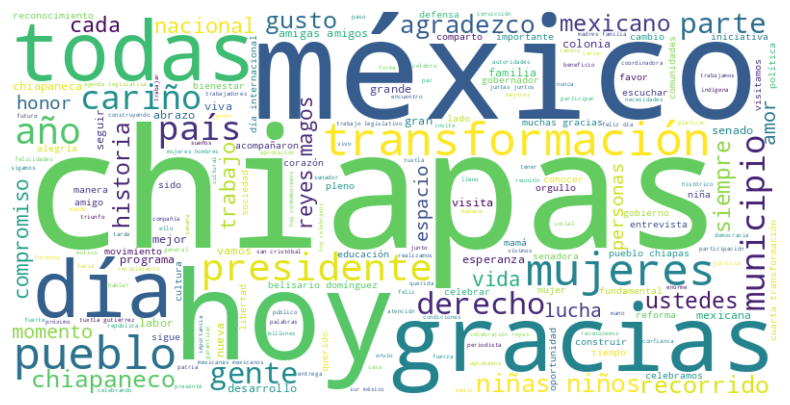

In [64]:
# Unir las palabras en un solo texto (separadas por espacios)
texto = " ".join(all_words)

# Crear el objeto WordCloud
nube_palabras = WordCloud(width=800, height=400, background_color='white').generate(texto)


# Mostrar la nube de palabras utilizando matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(nube_palabras, interpolation='bilinear')
plt.axis('off')  # Desactivar ejes
plt.show()


In [76]:
top_words

chiapas           114
méxico             78
hoy                68
gracias            64
transformación     53
día                49
mujeres            49
todas              49
pueblo             46
presidente         42
Name: count, dtype: int64

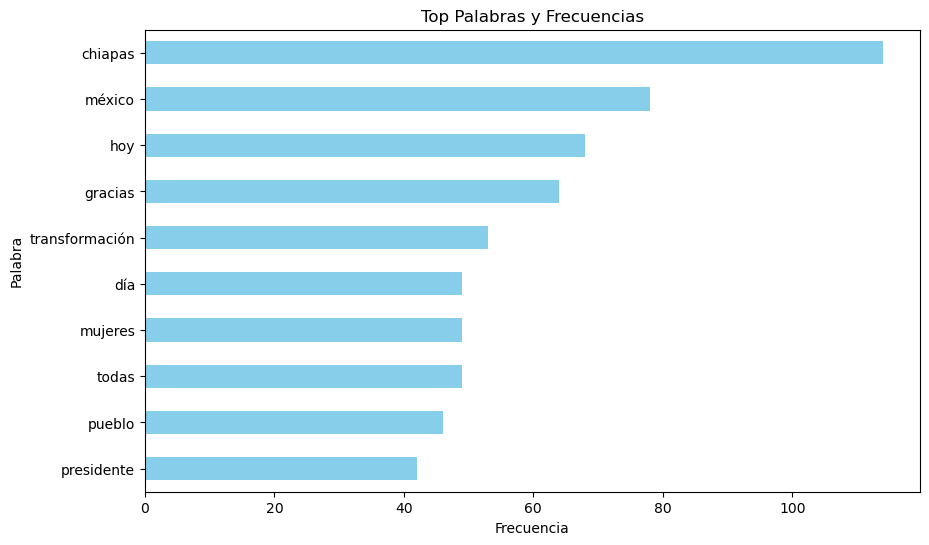

In [66]:
# Crear el gráfico de barras horizontal
plt.figure(figsize=(10, 6))
top_words.plot(kind='barh', color='skyblue')
plt.xlabel('Frecuencia')
plt.ylabel('Palabra')
plt.title('Top Palabras y Frecuencias')
plt.gca().invert_yaxis()  # Invertir el eje y para mostrar la palabra con la frecuencia más alta en la parte superior
plt.show()


In [67]:


# Convertir el gráfico de Matplotlib a Plotly
fig = go.Figure(data=[go.Bar(y=top_words.index, x=top_words.values, orientation='h')],
                layout=go.Layout(title='Top Palabras y Frecuencias'))

# Mostrar el gráfico de Plotly
fig.show()

In [54]:
tweets_tidy

,texto,tokens
0,méxico está listo para tener a la primera pres...,"[méxico, está, listo, para, tener, a, la, prim..."
1,trabajar por más de una década en favor de las...,"[trabajar, por, más, de, una, década, en, favo..."
2,¡por la continuidad de la transformación en ch...,"[por, la, continuidad, de, la, transformación,..."
3,| comenzamos la semana dialogando con,"[comenzamos, la, semana, dialogando, con]"
4,"cuando me pregunten si me registraré, habrá se...","[cuando, me, pregunten, si, me, registraré, ha..."
...,...,...
673,hoy cumplí con mi responsabilidad y mi derecho...,"[hoy, cumplí, con, mi, responsabilidad, y, mi,..."
674,mañana todas y todos podemos participar en est...,"[mañana, todas, y, todos, podemos, participar,..."
675,este domingo sal a participar en la consulta de,"[este, domingo, sal, a, participar, en, la, co..."
676,hoy en su cumpleaños quiero enviar una felicit...,"[hoy, en, su, cumpleaños, quiero, enviar, una,..."


In [55]:
# Función para obtener n-gramas de una lista de palabras
def obtener_ngramas(lista_palabras, n):
    threshold=3
    n_gramas = list(ngrams(lista_palabras, n))
    return [' '.join(grama) for grama in n_gramas if len(grama[0])>threshold and len(grama[1])>threshold]

# Obtener n-gramas de tamaño 2 (bigramas) para todas las filas
n = 2
tweets_tidy['bigramas'] = tweets_tidy.tokens.apply(lambda row: obtener_ngramas(row, n))

# Obtener n-gramas de tamaño 3 (trigramas) para todas las filas
n = 3
tweets_tidy['trigramas'] = tweets_tidy.tokens.apply(lambda row: obtener_ngramas(row, n))

# Mostrar el DataFrame con los n-gramas
tweets_tidy

NameError: name 'ngrams' is not defined

In [115]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

# Supongamos que tienes un corpus de textos en una lista llamada 'corpus_textos'



In [113]:
tweets_tidy.tokens

0      [méxico, está, listo, para, tener, a, la, prim...
1      [trabajar, por, más, de, una, década, en, favo...
2      [por, la, continuidad, de, la, transformación,...
3              [comenzamos, la, semana, dialogando, con]
4      [cuando, me, pregunten, si, me, registraré, ha...
                             ...                        
673    [hoy, cumplí, con, mi, responsabilidad, y, mi,...
674    [mañana, todas, y, todos, podemos, participar,...
675    [este, domingo, sal, a, participar, en, la, co...
676    [hoy, en, su, cumpleaños, quiero, enviar, una,...
677    [este, domingo, sal, a, participar, en, la, co...
Name: tokens, Length: 641, dtype: object

In [117]:
texts = tweets_tidy.tokens

punctuation = set(string.punctuation)

texts = [[word for word in doc if word not in stop_words and word not in punctuation] for doc in texts]

# Crear un diccionario de términos a partir del corpus
dictionary = corpora.Dictionary(texts)

# Crear una representación vectorial del corpus
corpus = [dictionary.doc2bow(text) for text in texts]

<class 'list'>


In [92]:
# Entrenar el modelo LDA
lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

# Obtener los temas y sus palabras clave
topics = lda_model.print_topics(num_words=5)

# Mostrar los temas y sus palabras clave
for topic in topics:
    print(topic)

(0, '0.009*"día" + 0.009*"2" + 0.007*"méxico" + 0.007*"viva" + 0.006*"hoy"')
(1, '0.014*"méxico" + 0.010*"chiapas" + 0.007*"transformación" + 0.006*"mujeres" + 0.006*"hoy"')
(2, '0.021*"chiapas" + 0.008*"transformación" + 0.007*"mujeres" + 0.006*"todas" + 0.006*"trabajo"')
(3, '0.021*"hoy" + 0.014*"chiapas" + 0.012*"méxico" + 0.009*"mujeres" + 0.008*"transformación"')
(4, '0.020*"gracias" + 0.012*"chiapas" + 0.010*"reyes" + 0.010*"niñas" + 0.010*"niños"')


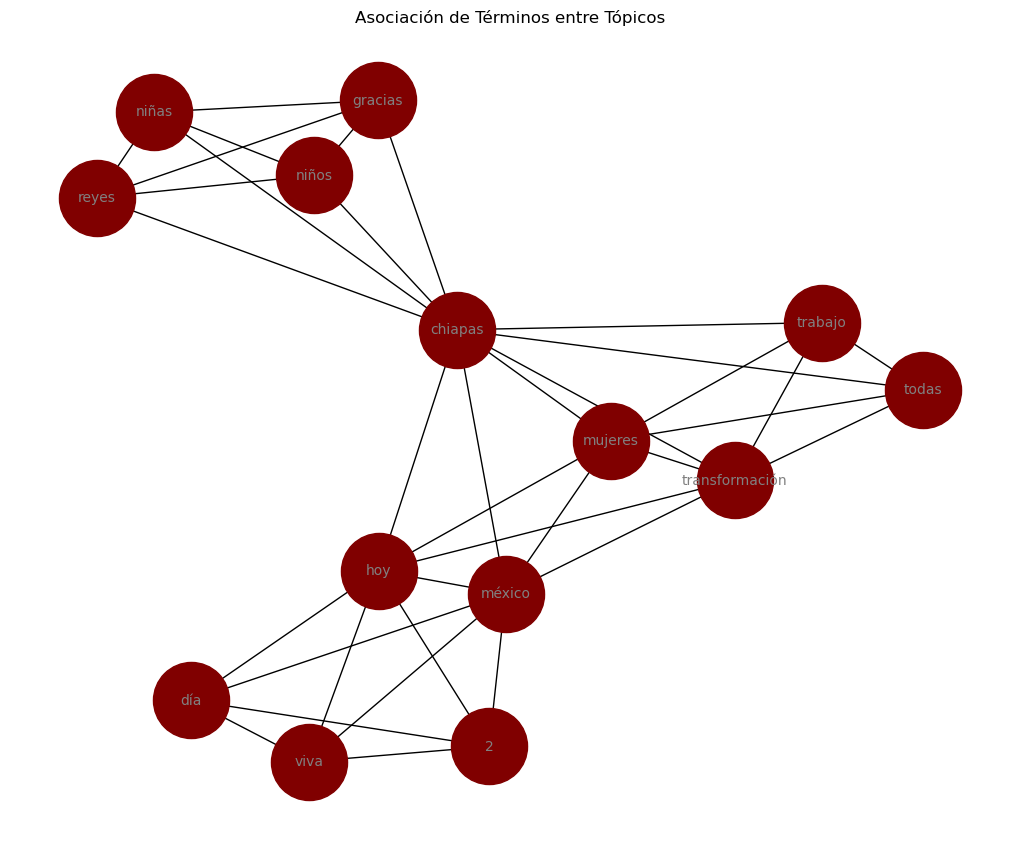

In [131]:
import networkx as nx
import matplotlib.pyplot as plt


# Crear un grafo de red
G = nx.Graph()

# Procesar los tópicos y sus palabras clave para identificar asociaciones
for topic_id, topic_words in topics:
    # Dividir las palabras clave en términos individuales
    terms = [term.split('*')[1].strip('"') for term in topic_words.split(' + ')]
    
    # Agregar una arista entre todos los términos del tópico
    for i in range(len(terms)):
        for j in range(i + 1, len(terms)):
            term1, term2 = terms[i], terms[j]
            G.add_edge(term1, term2, topic=topic_id)

# Dibujar el gráfico de red
pos = nx.spring_layout(G, k=0.3, iterations=50)
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, font_size=10, node_size=3000, node_color='maroon', font_color='gray')

# Mostrar el gráfico de red
plt.title('Asociación de Términos entre Tópicos')
# Guardar la figura como una imagen
plt.savefig('topicos.png', bbox_inches='tight', dpi=300)
plt.show()

In [107]:
import networkx as nx
import plotly.graph_objs as go

# Supongamos que 'topics' contiene las asociaciones entre términos en los tópicos (como se mencionó en el ejemplo anterior)

# Crear un grafo de red
G = nx.Graph()

# Procesar los tópicos y sus palabras clave para identificar asociaciones
for topic_id, topic_words in topics:
    # Dividir las palabras clave en términos individuales
    terms = [term.split('*')[1].strip('"') for term in topic_words.split(' + ')]
    
    # Agregar una arista entre todos los términos del tópico
    for i in range(len(terms)):
        for j in range(i + 1, len(terms)):
            term1, term2 = terms[i], terms[j]
            G.add_edge(term1, term2, topic=topic_id)

# Crear un layout para el gráfico de red
pos = nx.spring_layout(G, k=0.3, iterations=50)

# Crear nodos y aristas para Plotly
edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

node_trace = go.Scatter(
    x=[],
    y=[],
    text=['pos'],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        size=30,
        colorbar=dict(
            thickness=15,
            title='Tópico',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=2)))

for node in G.nodes():
    x, y = pos[node]
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])

# Crear un gráfico de red interactivo
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    showlegend=False,
                    margin=dict(b=0, l=0, r=0, t=0),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

fig.show()

In [112]:
import networkx as nx
import plotly.graph_objs as go

# Supongamos que 'topics' contiene las asociaciones entre términos en los tópicos (como se mencionó en el ejemplo anterior)

# Crear un grafo de red
G = nx.Graph()

# Procesar los tópicos y sus palabras clave para identificar asociaciones
for topic_id, topic_words in topics:
    # Dividir las palabras clave en términos individuales
    terms = [term.split('*')[1].strip('"') for term in topic_words.split(' + ')]
    
    # Agregar una arista entre todos los términos del tópico
    for i in range(len(terms)):
        for j in range(i + 1, len(terms)):
            term1, term2 = terms[i], terms[j]
            G.add_edge(term1, term2, topic=topic_id)

# Crear un layout para el gráfico de red
pos = nx.spring_layout(G, k=0.3, iterations=50)

# Crear nodos y aristas para Plotly
edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5, color='#888'),
    hoverinfo='text',
    mode='lines')

for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

node_trace = go.Scatter(
    x=[],
    y=[],
    text=["pos"],  # Aquí asignamos el texto (nombre de los nodos)
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        size=30,
        colorbar=dict(
            thickness=15,
            title='Tópico',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=2)))

for node in G.nodes():
    x, y = pos[node]
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])
    node_trace['text'] += tuple([node])  # Asignar el nombre del nodo como texto

# Crear un gráfico de red interactivo
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    showlegend=False,
                    margin=dict(b=0, l=0, r=0, t=0),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

fig.show()


In [101]:
import networkx as nx
import plotly.graph_objs as go

# Supongamos que 'topics' contiene las asociaciones entre términos en los tópicos (como se mencionó en el ejemplo anterior)

# Crear un grafo de red
G = nx.Graph()

# Procesar los tópicos y sus palabras clave para identificar asociaciones
for topic_id, topic_words in topics:
    # Dividir las palabras clave en términos individuales
    terms = [term.split('*')[1].strip('"') for term in topic_words.split(' + ')]
    
    # Agregar una arista entre todos los términos del tópico
    for i in range(len(terms)):
        for j in range(i + 1, len(terms)):
            term1, term2 = terms[i], terms[j]
            G.add_edge(term1, term2, topic=topic_id)

# Crear un layout para el gráfico de red
pos = nx.spring_layout(G, k=0.3, iterations=50)

# Crear nodos y aristas para Plotly
edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],  # Aquí asignamos el texto (nombre de los nodos)
    textposition='bottom center',  # Fijar la posición del texto
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        size=30,
        colorbar=dict(
            thickness=15,
            title='Tópico',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=2)))

for node in G.nodes():
    x, y = pos[node]
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])
    node_trace['text'] += tuple([node])  # Asignar el nombre del nodo como texto

# Crear un gráfico de red interactivo
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    showlegend=False,
                    margin=dict(b=0, l=0, r=0, t=0),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

fig.show()


In [73]:
import plotly.express as px
from wordcloud import WordCloud

# Supongamos que 'word_freq' contiene las frecuencias de palabras (como se mencionó en el ejemplo anterior)

# Crear una nube de palabras
#wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Crear una figura de Plotly
fig = px.imshow(nube_palabras, width=800, height=400)
fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0),
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
)
fig.show()


In [83]:
import networkx as nx
import plotly.graph_objs as go
import matplotlib.pyplot as plt


# Crear un grafo de red
G = nx.Graph()

# Procesar los tópicos y sus palabras clave para identificar asociaciones
for topic_id, topic_words in topics:
    # Dividir las palabras clave en términos individuales
    terms = [term.split('*')[1].strip('"') for term in topic_words.split(' + ')]
    
    # Agregar una arista entre todos los términos del tópico
    for i in range(len(terms)):
        for j in range(i + 1, len(terms)):
            term1, term2 = terms[i], terms[j]
            G.add_edge(term1, term2, topic=topic_id)

# Posiciones de los nodos
pos = nx.spring_layout(G, k=0.3, iterations=50)

# Crear los nodos y bordes para Plotly
node_trace = go.Scatter(
    x=[pos[x][0] for x in G.nodes()],
    y=[pos[x][1] for x in G.nodes()],
    mode='markers+text',
    text=list(G.nodes()),
    textposition='bottom center',
    hoverinfo='text',
    marker=dict(
        showscale=False,
        size=20,
        color='skyblue'
    )
)

edge_trace = go.Scatter(
    x=[pos[x[0]][0] for x in G.edges()],
    y=[pos[x[0]][1] for x in G.edges()],
    line=dict(width=2, color='gray'),
    hoverinfo='none',
    mode='lines'
)

# Crear la figura de Plotly
fig_network = go.Figure(data=[edge_trace, node_trace],
                        layout=go.Layout(
                            showlegend=False,
                            hovermode='closest',
                            margin=dict(b=0, l=0, r=0, t=0)
                        ))

# Mostrar la figura de Plotly
fig_network.show()


In [69]:
import re

tweets_tidy['texto'] = tweets_tidy['texto'].apply(lambda x: re.sub(r'[^\w\s]', '', x.lower()))

# Función para obtener el sentimiento de un texto
def obtener_sentimiento(texto):
    analyzer = SentimentIntensityAnalyzer()
    return analyzer.polarity_scores(texto)["compound"]

# Aplicar la función a la columna "texto" y crear una nueva columna "sentimiento"
tweets_tidy["sentimiento"] = tweets_tidy["texto"].apply(obtener_sentimiento)
tweets_tidy.to_csv("tweets_posts_sentiment.csv")

In [70]:
import plotly.graph_objects as go

####################################
# Contar la cantidad de sentimientos negativos, neutros y positivos
negativos = tweets_tidy[tweets_tidy["sentimiento"] < 0].count().values[0]
neutros = tweets_tidy[tweets_tidy["sentimiento"] == 0].count().values[0]
positivos = tweets_tidy[tweets_tidy["sentimiento"] > 0].count().values[0]

# Crear la gráfica de pastel
labels = ["Negativos", "Neutros", "Positivos"]
values = [negativos, neutros, positivos]

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])


# Mostrar la gráfica
fig.show()